Here's the schema for the Northwind database:

<img src='images/Northwind_ERD_updated.png'>

## Import libraries

In [91]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

In [2]:
#Connect to server and create cursor
conn = sqlite3.connect('northwind_small.sqlite')
c = conn.cursor()

In [3]:
#Create a list of table names and check
table_names = [name[0] for name 
               in c.execute("""SELECT name FROM sqlite_master 
                            WHERE type='table';""").fetchall()]
table_names

['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 'Order',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

In [4]:
#Create dataframes for each table and check
dfs = []
for table in table_names:
    df = pd.read_sql_query('SELECT * from "'+table+'"', conn)
    new_df_name = table.lower()+"_df" #creates string for new df name
    exec(new_df_name + " = df") #creates df with new name
    #exec() dynamically executes a line of code
    dfs.append(new_df_name)
dfs

['employee_df',
 'category_df',
 'customer_df',
 'shipper_df',
 'supplier_df',
 'order_df',
 'product_df',
 'orderdetail_df',
 'customercustomerdemo_df',
 'customerdemographic_df',
 'region_df',
 'territory_df',
 'employeeterritory_df']

In [5]:
#Check the tricky one
order_df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


# Question 1

**Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?**

* Null hypothesis: Discount has no effect on quantity ordered. 
* Alternative hypothesis: Discount has a statistically significant effect on quantity ordered. Specify level(s) of discount.

Query ideas
* how many orders had discounts
* compare quantity of item with discount and without discount

In [6]:
#Inspect values counts of discounts
orderdetail_df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

Most discounts fall into one of six bins: 0, 0.05, 0.10, 0.15, 0.20, and 0.25. The other five bins have very little data. I could either ignore these orders or lump the discounts together by groups of 5%. 

In [7]:
1317/2155

0.6111368909512761

In [8]:
orderdetail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [9]:
# how many orders had discounts
query = '''SELECT * FROM OrderDetail WHERE Discount > 0'''

In [10]:
discount_df = pd.read_sql(query, conn)
discount_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.4,35,0.15
1,10250/65,10250,65,16.8,15,0.15
2,10251/22,10251,22,16.8,6,0.05
3,10251/57,10251,57,15.6,15,0.05
4,10252/20,10252,20,64.8,40,0.05


In [11]:
discount_df.Discount.value_counts()

0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
0.03      3
0.02      2
0.04      1
0.06      1
0.01      1
Name: Discount, dtype: int64

Eliminate noise of discounts with limited data.

Groups for discounts
* d = 0.05
* d = 0.10
* d = 0.15
* d = 0.20
* d = 0.25

In [60]:
q0 = '''SELECT * FROM OrderDetail 
    WHERE Discount == 0.0'''

In [61]:
d0_df = pd.read_sql(q0, conn)
d0_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [62]:
q1 = '''SELECT * FROM OrderDetail 
    WHERE Discount == 0.05'''

In [63]:
d05_df = pd.read_sql(q1, conn)
d05_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10251/22,10251,22,16.8,6,0.05
1,10251/57,10251,57,15.6,15,0.05
2,10252/20,10252,20,64.8,40,0.05
3,10252/33,10252,33,2.0,25,0.05
4,10266/12,10266,12,30.4,12,0.05


In [64]:
q2 = '''SELECT * FROM OrderDetail 
    WHERE Discount == 0.10'''

In [65]:
d10_df = pd.read_sql(q2, conn)
d10_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10288/54,10288,54,5.9,10,0.1
1,10288/68,10288,68,10.0,3,0.1
2,10291/13,10291,13,4.8,20,0.1
3,10291/44,10291,44,15.5,24,0.1
4,10291/51,10291,51,42.4,2,0.1


In [66]:
q3 = '''SELECT * FROM OrderDetail 
    WHERE Discount == 0.15'''

In [67]:
d15_df = pd.read_sql(q3, conn)
d15_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.4,35,0.15
1,10250/65,10250,65,16.8,15,0.15
2,10254/24,10254,24,3.6,15,0.15
3,10254/55,10254,55,19.2,21,0.15
4,10264/41,10264,41,7.7,25,0.15


In [68]:
q4 = '''SELECT * FROM OrderDetail 
    WHERE Discount == 0.20'''

In [69]:
d20_df = pd.read_sql(q4, conn)
d20_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10258/2,10258,2,15.2,50,0.2
1,10258/5,10258,5,17.0,65,0.2
2,10258/32,10258,32,25.6,6,0.2
3,10262/5,10262,5,17.0,12,0.2
4,10285/1,10285,1,14.4,45,0.2


In [70]:
q5 = '''SELECT * FROM OrderDetail 
    WHERE Discount == 0.25'''

In [71]:
d25_df = pd.read_sql(q5, conn)
d25_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10260/41,10260,41,7.7,16,0.25
1,10260/62,10260,62,39.4,15,0.25
2,10260/70,10260,70,12.0,21,0.25
3,10263/16,10263,16,13.9,60,0.25
4,10263/30,10263,30,20.7,60,0.25


In [82]:
display('Stat Summary - No Discount')
display(d0_df.Quantity.describe())
display('Stat Summary - 5% Discount')
display(d05_df.Quantity.describe())

'Stat Summary - No Discount'

count    1317.000000
mean       21.715262
std        17.507493
min         1.000000
25%        10.000000
50%        18.000000
75%        30.000000
max       130.000000
Name: Quantity, dtype: float64

'Stat Summary - 5% Discount'

count    185.000000
mean      28.010811
std       22.187685
min        1.000000
25%       14.000000
50%       20.000000
75%       40.000000
max      120.000000
Name: Quantity, dtype: float64

In [84]:
display('Stat Summary - 10% Discount')
display(d10_df.Quantity.describe())
display('Stat Summary - 15% Discount')
display(d15_df.Quantity.describe())

'Stat Summary - 10% Discount'

count    173.000000
mean      25.236994
std       21.186503
min        2.000000
25%       10.000000
50%       20.000000
75%       30.000000
max      130.000000
Name: Quantity, dtype: float64

'Stat Summary - 15% Discount'

count    157.000000
mean      28.382166
std       20.923099
min        2.000000
25%       15.000000
50%       21.000000
75%       40.000000
max      100.000000
Name: Quantity, dtype: float64

In [85]:
display('Stat Summary - 20% Discount')
display(d20_df.Quantity.describe())
display('Stat Summary - 25% Discount')
display(d25_df.Quantity.describe())

'Stat Summary - 20% Discount'

count    161.000000
mean      27.024845
std       18.832801
min        2.000000
25%       12.000000
50%       21.000000
75%       40.000000
max      100.000000
Name: Quantity, dtype: float64

'Stat Summary - 25% Discount'

count    154.00000
mean      28.24026
std       20.12057
min        2.00000
25%       15.00000
50%       25.00000
75%       36.00000
max      120.00000
Name: Quantity, dtype: float64

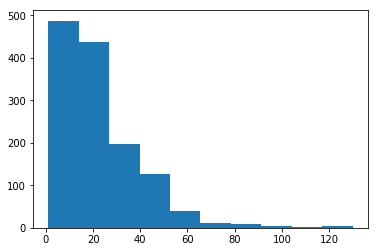

In [90]:
plt.hist(d0_df.Quantity)
plt.show()

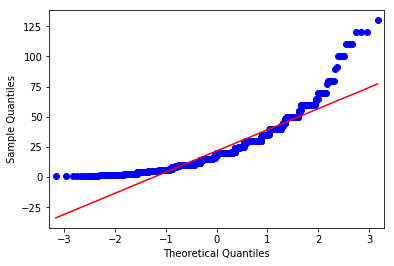

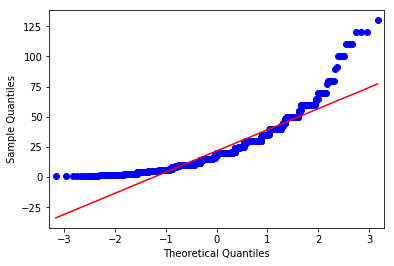

In [93]:
sm.qqplot(d0_df.Quantity, line='s')

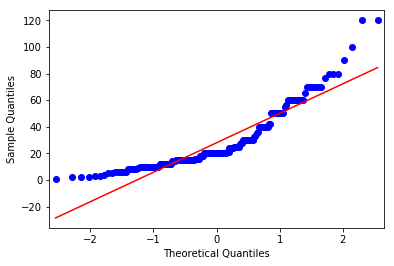

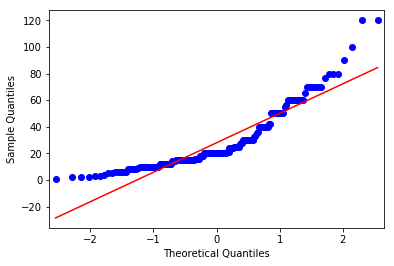

In [94]:
sm.qqplot(d05_df.Quantity, line='s')

In [107]:
n = int(.8*len(d0_df.Quantity))
len(bootstrap(d0_df.Quantity, n))

1053

In [98]:
len(d0_df)

1317

In [ ]:
iterations = 10**4
diff_mu_a_b = np.mean(a) - np.mean(b)
num = 0 #Initialize numerator
for n in range(iterations):
    ai = bootstrap(a, len(a))
    bi = bootstrap(b, len(b))
    diff_mu_ai_bi = np.mean(ai) - np.mean(bi)
    if diff_mu_ai_bi >= diff_mu_a_b:
        num +=1
p_val = num / iterations
print('P-value: {}'.format(p_val))

our data does not meet the normality assumption

I need a sampling distribution that is normally distributed.
I will use bootstrapping to get a bunch of samples and take a sampling distribution from that. 

for each dataset:
    * no discount
    * discount
    * each level of discount
    
pick sample size 
take sample
bootstrap 10000 times 
find the mean quantity ordered (for each productid?) of each sample
put all those means into an array
check normality of sampling distribution
run ANOVA
analyze p value
OR
run tukey for each level of discount

What if I looked up the mean of quantity ordered by product id? Are products ordered both with and without discounts?

In [25]:
d0_df.ProductId.nunique()

77

In [26]:
discount_df.ProductId.nunique()

77

In [27]:
orderdetail_df.ProductId.nunique()

77

In [28]:
d0_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1317 entries, 0 to 1316
Data columns (total 6 columns):
Id           1317 non-null object
OrderId      1317 non-null int64
ProductId    1317 non-null int64
UnitPrice    1317 non-null float64
Quantity     1317 non-null int64
Discount     1317 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 61.8+ KB


In [29]:
discount_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 6 columns):
Id           838 non-null object
OrderId      838 non-null int64
ProductId    838 non-null int64
UnitPrice    838 non-null float64
Quantity     838 non-null int64
Discount     838 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 39.4+ KB


In [30]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
Id                 77 non-null int64
ProductName        77 non-null object
SupplierId         77 non-null int64
CategoryId         77 non-null int64
QuantityPerUnit    77 non-null object
UnitPrice          77 non-null float64
UnitsInStock       77 non-null int64
UnitsOnOrder       77 non-null int64
ReorderLevel       77 non-null int64
Discontinued       77 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 6.1+ KB


In [31]:
product_df.Id.nunique()

77

I want to make a table based on product id with a column for mean quantity ordered with discount and mean quantity ordered without discount.

I can start by testing one product id to see how the price and quantity compare with and without discounts. 

In [54]:
orderdetail_df.loc[orderdetail_df.ProductId == 50]

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
272,10350/50,10350,50,13.00,15,0.10
358,10383/50,10383,50,13.00,15,0.00
479,10429/50,10429,50,13.00,40,0.00
581,10465/50,10465,50,13.00,25,0.00
1027,10637/50,10637,50,16.25,25,0.05
1272,10729/50,10729,50,16.25,40,0.00
1327,10751/50,10751,50,16.25,20,0.10
1745,10920/50,10920,50,16.25,24,0.00
1814,10948/50,10948,50,16.25,9,0.00
2119,11072/50,11072,50,16.25,22,0.00


In [49]:
product_df.loc[product_df.Id == 11].head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
10,11,Queso Cabrales,5,4,1 kg pkg.,21.0,22,30,30,0


I want to know if the mean of the quantity ordered with discount is greater than the mean of the quantity ordered without discount

productid | productname | categoryid | quantityperunit

In [56]:
#graph of average quantity ordered at different discount rates

# Removing the noise of the smaller discount levels that were not tested due to inadequate sample size
relevant_discounts_df = orderdetail_df[(orderdetail_df['Discount'] == 0) | 
                                          (orderdetail_df['Discount'] == 0.05) |
                                          (orderdetail_df['Discount'] == 0.1) |
                                          (orderdetail_df['Discount'] == 0.15) |
                                          (orderdetail_df['Discount'] == 0.2) |
                                          (orderdetail_df['Discount'] == 0.25)]



The bootstrap method works by taking random samples with replacement from the original sample. 

In [104]:
def bootstrap(sample, n):
    return np.random.choice(sample, size=n, replace=True)

In [ ]:
iterations = 10**4
diff_mu_a_b = np.mean(a) - np.mean(b)
num = 0 #Initialize numerator
for n in range(iterations):
    ai = bootstrap(a, len(a))
    bi = bootstrap(b, len(b))
    diff_mu_ai_bi = np.mean(ai) - np.mean(bi)
    if diff_mu_ai_bi >= diff_mu_a_b:
        num +=1
p_val = num / iterations
print('P-value: {}'.format(p_val))


* figure out metric to measure
* test normality
* bootstrap
* test normality
* 

**State the hypothesis**



Calculate Cohen's d to measure Effect Size

The difference between means divided by the pooled standard deviation

In [59]:
def cohens_d(group1, group2):
    
    """Return Cohen's d to evaluate effect size
    Cohen's d = difference between means of two groups divided by their pooled standard deviation
    0.2 = small effect
    0.5 = medium effect
    0.8 large effect
    
    Input:
    group1 (array) : array of numbers
    group2 (array) : array of numbers
    
    Return:
    d : Cohen's D (Effect Size)
    """
    numer = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    denom = np.sqrt(pooled_var)
    return numer / denom

In [ ]:
def get_column_info(col_name): #quick function based on https://github.com/learn-co-curriculum/dsc-2-13-11-queries-with-sqlalchemy-lab
    col_list = inspector.get_columns(col_name)
    print(f'Table Name: {col_name} \n')
    
    for col in col_list:
        if col['primary_key'] == 1:
            print(f"{col['name']}  ||PRIMARY KEY||  dtype: {col['type']}")
        else:
            print(f"{col['name']}     dtype: {col['type']}")